<img src="https://www.grag.ai/wp-content/uploads/2024/12/GRAG-ICON-TO-WORDLOGO-Animation_Loop-small-ezgif.com-video-to-gif-converter.gif" alt="GRAG Logo" width="400" style="margin-left:'auto' margin-right:'auto' display:'block'"/>

# Evaluating **RAG TASKS** of [GRAG-LLM-HARD-BENCHMARK](https://huggingface.co/datasets/avemio/GRAG-LLM-HARD-BENCHMARK)


In [1]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
model_name="GPT-4o-mini"
folder_path="evaluated/"+ "judged"
output_directory = "evaluated/"+ "weighted"

In [3]:
def compute_weighted_score(row,
                           reasoning_col_exists,
                           threshold_variable,
                           metrics_to_use,
                           weights,
                           df=None,
                           idx=None):
    """
    Computes a weighted score for the given row.
    Optionally updates `df` if row values need to be changed.

    Parameters:
    -----------
    row : pd.Series
        The row of data from the DataFrame.
    reasoning_col_exists : bool
        Flag indicating if reasoning metrics exist.
    threshold_variable : float
        The threshold to check final_solution_correctness against.
    metrics_to_use : list
        List of metric column names to consider.
    weights : dict
        Dictionary mapping metric names to their weights.
    df : pd.DataFrame or None
        If provided, this function will update the df's metrics for the given row.
    idx : int or None
        The index of the row in the df.

    Returns:
    --------
    float
        The computed weighted score.
    """

    # Case 1: Reasoning scenario with final_solution_correctness below threshold
    if reasoning_col_exists and row['final_solution_correctness'] < threshold_variable:
        # Zero out all metrics except logical_consistency
        if df is not None and idx is not None:
            for m in metrics_to_use:
                if m in df.columns and m != 'logical_consistency':
                    df.at[idx, m] = 0

        # Prepare weights so that only logical_consistency contributes
        row_weights = {
            m: (weights[m] if m == 'logical_consistency' else 0)
            for m in metrics_to_use
        }

        # Compute weighted sum using only logical_consistency
        total_weight = sum(row_weights.values())
        if total_weight == 0:
            # If logical_consistency has zero weight, return 0
            return 0

        val = row.get('logical_consistency', np.nan)
        if pd.isna(val):
            # If logical_consistency is NaN, there's nothing to score
            return 0

        # Multiply logical_consistency by its weight
        current_weighted_score = val * row_weights['logical_consistency']

    else:
        # Case 2: Normal scenario (or final_solution_correctness >= threshold)
        row_weights = dict(weights)

        # Redistribute weights if any metric is NaN
        for m in metrics_to_use:
            if pd.isna(row.get(m, np.nan)):
                row_weights['overall_correctness'] = (
                    row_weights.get('overall_correctness', 0) + row_weights.get(m, 0)
                )
                row_weights[m] = 0

        # Compute weighted sum
        total_score = 0
        total_weight = sum(row_weights.values()) or 1  # avoid division by zero

        for m, w in row_weights.items():
            val = row.get(m, np.nan)
            if pd.isna(val):
                continue
            total_score += val * w

        current_weighted_score = total_score / total_weight

    return current_weighted_score


In [4]:
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

print(files)

['extracted_judged_evaluated_hard-reasoning-de_test.csv', 'extracted_judged_evaluated_summarize-meeting-topic_test.csv', 'extracted_judged_evaluated_hard-reasoning-en_test.csv', 'extracted_judged_evaluated_summarize-meeting-attendee-topic_test.csv', 'extracted_judged_evaluated_hard-qa-with-multiple-references_test.csv']


In [5]:
print(os.path.join(folder_path, files[1]))

evaluated/judged/extracted_judged_evaluated_summarize-meeting-topic_test.csv


In [6]:
# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

In [7]:
list_reasoning=["extracted_judged_evaluated_hard-reasoning-de_test.csv","extracted_judged_evaluated_hard-reasoning-en_test.csv"]

list_non_binary=["extracted_judged_evaluated_summarize-meeting-attendee-topic_test.csv","extracted_judged_evaluated_summarize-meeting-topic_test.csv", "extracted_judged_evaluated_hard-reasoning-de_test.csv","extracted_judged_evaluated_hard-reasoning-en_test.csv"]

list_overall_correctness=["extracted_judged_evaluated_hard-reasoning-de_test.csv","extracted_judged_evaluated_hard-reasoning-en_test.csv"]

list_language_quality=["extracted_judged_evaluated_hard-qa-with-multiple-references_test.csv"]

exclude_list = [] # Use this to exclude tasks from the Plot

In [8]:
def calculate_overall_score(row, weights):
    if 'overall_correctness_binary_score' in weights:
        return (
        row['language_quality'] * weights['language_quality']
        + row['overall_correctness'] * weights['overall_correctness']
        + row['instruction_following'] * weights['instruction_following']
        + row['overall_correctness_binary_score'] * weights['overall_correctness_binary_score']
    )
    elif 'final_solution_correctness'in weights:
        return (
        row['language_quality'] * weights['language_quality']
        + row['overall_correctness'] * weights['overall_correctness']
        + row['instruction_following'] * weights['instruction_following']
        + row['constrains_adherence'] * weights['constrains_adherence']
        + row['logical_consistency'] * weights['logical_consistency']
        + row['final_solution_correctness'] * weights['final_solution_correctness']
    )
    else:
        return (
        row['language_quality'] * weights['language_quality']
        + row['overall_correctness'] * weights['overall_correctness']
        + row['instruction_following'] * weights['instruction_following']
    )

In [9]:
# hard-qa-multiple-references
weights_binary_correctness = {
    'overall_correctness': 0.5,
    'instruction_following': 0.2,
    'overall_correctness_binary_score': 0.3,
}

weights_binary_language = {
    'language_quality': 0.4,
    'overall_correctness': 0.3,
    'instruction_following': 0.15,
    'overall_correctness_binary_score': 0.15,
}


weights_non_binary_correctness = {
    'language_quality': 0,
    'overall_correctness': 0.6,
    'instruction_following': 0.4,
}

weights_non_binary_language = {
    'language_quality': 0.4,
    'overall_correctness': 0.4,
    'instruction_following': 0.2,
}
# hard reasoning
weights_reasoning = {
    'constrains_adherence': 0.3,
    'logical_consistency': 0.3,
    'final_solution_correctness': 0.4
}

In [10]:
for file in files:
    print(file)

    if file not in exclude_list:
        # Read the CSV file into a DataFrame
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, sep=';')

        # Exclude rows where all specified columns are 0
        df = df.loc[~((df['language_quality'] == 0) & (df['overall_correctness'] == 0) & (df['instruction_following'] == 0))]
        df = df.loc[~(df['model_generated_output'] == 'Error generating response')]

        if file not in list_non_binary:
            # Apply different logic based on file name
            if file == 'extracted_judged_evaluated_hard-qa-with-multiple-references_test.csv':
                df['overall_correctness_binary_score'] = df.apply(
                    lambda row: 100 if row['References'] == row['model_References'] else 0, axis=1
                )

            df['overall_score'] = df[['language_quality', 'overall_correctness', 'instruction_following', 'overall_correctness_binary_score']].mean(axis=1)

            if file in list_language_quality:
                df['weighted_overall_score'] = df.apply(calculate_overall_score, axis=1, weights=weights_binary_language)
            else:
                df['weighted_overall_score'] = df.apply(calculate_overall_score, axis=1, weights=weights_binary_correctness)

        else:
            df['overall_score'] = df[['language_quality', 'overall_correctness', 'instruction_following']].mean(axis=1)

            if file in list_overall_correctness:
                df['weighted_overall_score'] = df.apply(calculate_overall_score, axis=1, weights=weights_non_binary_correctness)
            else:
               if file == "extracted_judged_evaluated_hard-reasoning-de_test.csv":
                df['weighted_overall_score'] = df.apply(calculate_overall_score, axis=1, weights=weights_reasoning)
               elif file == "extracted_judged_evaluated_hard-reasoning-en_test.csv":
                df['weighted_overall_score'] = df.apply(calculate_overall_score, axis=1, weights=weights_reasoning)
               else:
                df['weighted_overall_score'] = df.apply(calculate_overall_score, axis=1, weights=weights_non_binary_language)

        # Save the updated DataFrame to a new CSV file
        output_file = os.path.join(output_directory, file.replace('.csv', '_weighted.csv'))
        df.to_csv(output_file, index=False, sep=';')


extracted_judged_evaluated_hard-reasoning-de_test.csv
extracted_judged_evaluated_summarize-meeting-topic_test.csv
extracted_judged_evaluated_hard-reasoning-en_test.csv
extracted_judged_evaluated_summarize-meeting-attendee-topic_test.csv
extracted_judged_evaluated_hard-qa-with-multiple-references_test.csv


In [11]:
files = [f for f in os.listdir(output_directory) if os.path.isfile(os.path.join(output_directory, f))]

print(files)

['extracted_judged_evaluated_hard-qa-with-multiple-references_test_weighted.csv', 'extracted_judged_evaluated_summarize-meeting-topic_test_weighted.csv', 'extracted_judged_evaluated_summarize-meeting-attendee-topic_test_weighted.csv', 'extracted_judged_evaluated_hard-reasoning-en_test_weighted.csv', 'extracted_judged_evaluated_hard-reasoning-de_test_weighted.csv']


# plotting the **result**

In [12]:
ordered_list=[
"extracted_judged_evaluated_hard-reasoning-de_test_weighted.csv",
"extracted_judged_evaluated_hard-reasoning-en_test_weighted.csv",
"extracted_judged_evaluated_hard-qa-with-multiple-references_test_weighted.csv",
"extracted_judged_evaluated_summarize-meeting-attendee-topic_test_weighted.csv",
"extracted_judged_evaluated_summarize-meeting-topic_test_weighted.csv"
]

In [13]:
list_overall_correctness=["extracted_judged_evaluated_hard-qa-with-multiple-references_test_weighted.csv", "extracted_judged_evaluated_summarize-meeting-attendee-topic_test_weighted.csv", "extracted_judged_evaluated_summarize-meeting-topic_test_weighted.csv"]

In [14]:
!wget -O /content/Montserrat-Regular.ttf "https://github.com/JulietaUla/Montserrat/blob/master/fonts/ttf/Montserrat-Regular.ttf?raw=true"
!wget -O /content/Montserrat-Bold.ttf "https://github.com/JulietaUla/Montserrat/blob/master/fonts/ttf/Montserrat-Bold.ttf?raw=true"

--2025-01-12 17:52:34--  https://github.com/JulietaUla/Montserrat/blob/master/fonts/ttf/Montserrat-Regular.ttf?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JulietaUla/Montserrat/raw/refs/heads/master/fonts/ttf/Montserrat-Regular.ttf [following]
--2025-01-12 17:52:35--  https://github.com/JulietaUla/Montserrat/raw/refs/heads/master/fonts/ttf/Montserrat-Regular.ttf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JulietaUla/Montserrat/refs/heads/master/fonts/ttf/Montserrat-Regular.ttf [following]
--2025-01-12 17:52:35--  https://raw.githubusercontent.com/JulietaUla/Montserrat/refs/heads/master/fonts/ttf/Montserrat-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.

In [15]:
file_path = os.path.join(output_directory, ordered_list[0])
df=pd.read_csv(file_path, sep=";")

In [16]:
bins = range(0, 110, 10)  # Intervals from 0 to 100 in steps of 10
labels = [f"{i}-{i+10}%" for i in bins[:-1]]

# Bin the data into intervals
df['interval'] = pd.cut(df['final_solution_correctness'], bins=bins, labels=labels, right=False)

# Count the values in each interval
interval_counts = df['interval'].value_counts().sort_index()

print(interval_counts)

interval
0-10%       0
10-20%      1
20-30%      2
30-40%      3
40-50%      5
50-60%     13
60-70%     17
70-80%     19
80-90%     18
90-100%    15
Name: count, dtype: int64


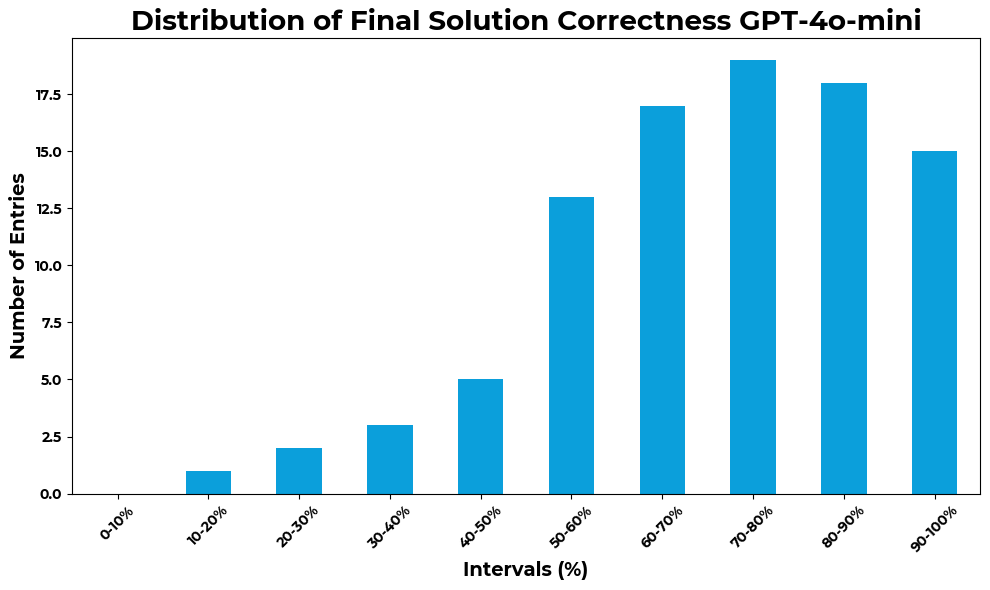

In [17]:
# Plotting the interval counts
interval_counts.plot(kind='bar', figsize=(10, 6), color='#0B9FDB')
montserrat_bold = fm.FontProperties(fname="/content/Montserrat-Bold.ttf")
montserrat_bold_title = montserrat_bold.copy()
montserrat_bold_title.set_size(20)
montserrat_bold_title.set_weight('bold')

# Adding labels and title
plt.title("Distribution of Final Solution Correctness "+ model_name, fontsize=20, fontproperties=montserrat_bold_title)
plt.xlabel("Intervals (%)", fontsize=14, fontproperties=montserrat_bold)
plt.ylabel("Number of Entries", fontsize=14, fontproperties=montserrat_bold)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=12, fontproperties=montserrat_bold)
plt.yticks(fontsize=12, fontproperties=montserrat_bold)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
full_metrics = [
    'Language Quality',
    'Overall Correctness',
    'Instruction Following',
    'Overall Correctness Binary Score',
    'Constrains Adherence',
    'Logical Consistency',
    'Final Solution Correctness',
    'Weighted Overall Score'
]

color_map = {
    'Language Quality': '#18A2D9',
    'Overall Correctness':  '#306CB4',
    'Instruction Following': '#794C99',
    'Overall Correctness Binary Score': '#F2CE1B',
    'Constrains Adherence': '#AFDDF0',
    'Logical Consistency': '#0B9FDB',
    'Final Solution Correctness': '#2882A6',
    'Weighted Overall Score': '#6BBA76'
}

legend_name_map = {
    'Language Quality': 'Language Quality',
    'Overall Correctness': 'Overall Correctness',
    'Instruction Following': 'Instruction Following',
    'Overall Correctness Binary Score': 'Source Citation',
    'Constrains Adherence': 'Constrains Adherence',
    'Logical Consistency': 'Logical Consistency',
    'Final Solution Correctness': 'Final Solution Correctness',
    'Weighted Overall Score': 'Weighted Overall Score'
}

results = {}
montserrat_bold = fm.FontProperties(fname="/content/Montserrat-Bold.ttf")

In [19]:
threshold_variable=70
folder_path= output_directory
print(model_name)

GPT-4o-mini


In [20]:
def update_weighted_overall_score(df, weights=weights_binary_correctness):
    """
    Updates the 'weighted_overall_score' column in the DataFrame based on the given weights.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the columns defined in the weights dictionary.
    weights : dict
        A dictionary defining the weights for each column.

    Returns:
    --------
    pandas.DataFrame
        The updated DataFrame with the 'weighted_overall_score' column.
    """
    # Ensure all relevant columns exist in the DataFrame
    for col in weights.keys():
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is not present in the DataFrame.")

    # Compute weighted overall score for each row
    def compute_weighted_score(row):
        weighted_sum = sum(row[col] * weight for col, weight in weights.items() if not pd.isna(row[col]))
        total_weight = sum(weight for col, weight in weights.items() if not pd.isna(row[col]))
        return weighted_sum / total_weight if total_weight > 0 else 0

    # Apply the computation to each row
    df['weighted_overall_score'] = df.apply(compute_weighted_score, axis=1)

    return df

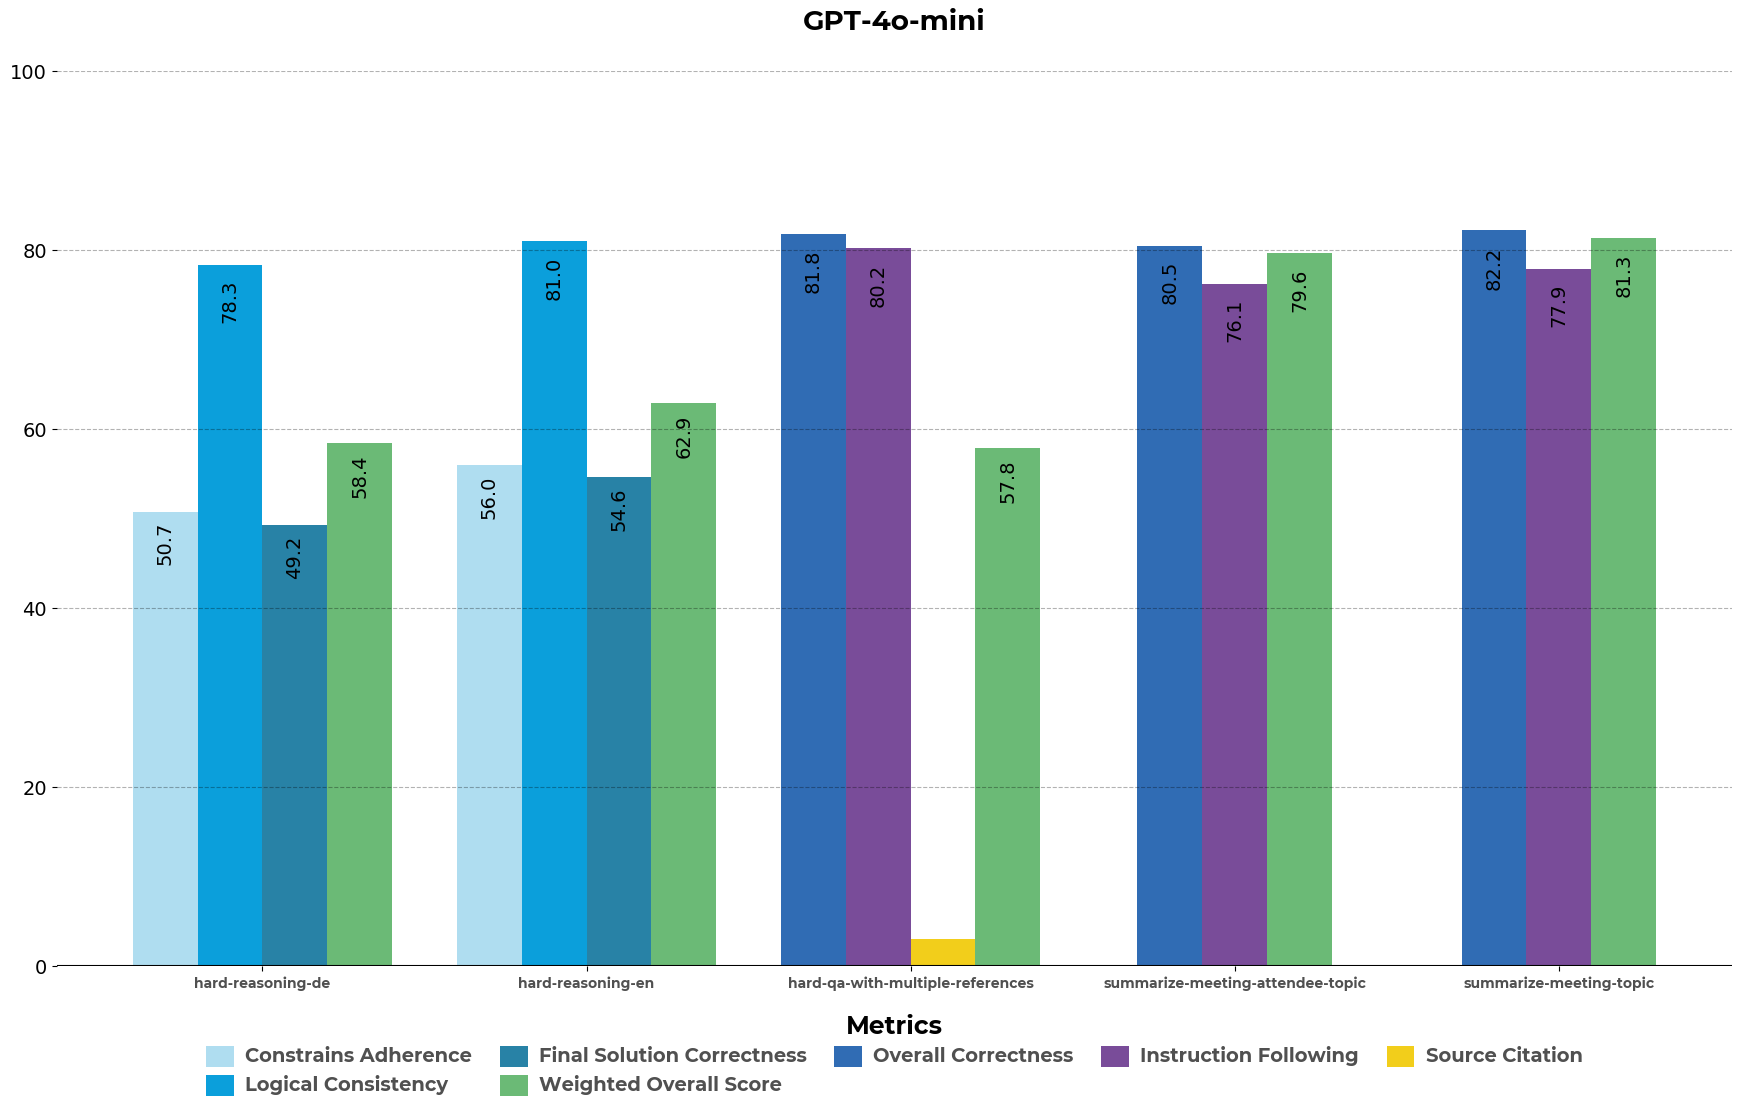

In [21]:
for file in ordered_list:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep=";")

    # Drop rows where overall_correctness is NaN
    df = df.dropna(subset=['overall_correctness'])

    # Check if columns exist
    binary_col_exists = 'overall_correctness_binary_score' in df.columns
    reasoning_col_exists = 'final_solution_correctness' in df.columns
    constrains_col_exists = 'constrains_adherence' in df.columns
    logic_col_exists = 'logical_consistency' in df.columns

    if binary_col_exists:
      df=update_weighted_overall_score(df)
    # Extract task name
    task_name = file.split('_evaluated')[1].split('_test')[0].lstrip('_')

    if reasoning_col_exists:
        # Reasoning scenario
        weights = weights_reasoning
        metrics_to_use = [
            'constrains_adherence',
            'logical_consistency',
            'final_solution_correctness'
        ]
    else:
        weights = weights_binary_correctness
        metrics_to_use = ['overall_correctness', 'instruction_following', 'overall_correctness_binary_score']

    # Apply the weighting row by row
    weighted_scores = []
    for idx, row in df.iterrows():
      score = compute_weighted_score(
        row=row,
        reasoning_col_exists=reasoning_col_exists,
        threshold_variable=threshold_variable,
        metrics_to_use=metrics_to_use,
        weights=weights,
        df=df,
        idx=idx
    )
      weighted_scores.append(score)

    # Add the weighted_overall_score column
    df['weighted_overall_score'] = weighted_scores

    # Identify metrics present in both full_metrics and the DataFrame
    columns_for_avg = [m.lower().replace(' ', '_') for m in full_metrics]  # convert full_metrics to lowercase snake_case to match df columns
    # We must ensure we are mapping the original metrics to their corresponding df columns:
    metric_column_map = {
        'Language Quality': 'language_quality',
        'Overall Correctness': 'overall_correctness',
        'Instruction Following': 'instruction_following',
        'Overall Correctness Binary Score': 'overall_correctness_binary_score',
        'Constrains Adherence': 'constrains_adherence',
        'Logical Consistency': 'logical_consistency',
        'Final Solution Correctness': 'final_solution_correctness',
        'Weighted Overall Score': 'weighted_overall_score'
    }


    if reasoning_col_exists:
      # Only include reasoning metrics
      relevant_metrics = ['Constrains Adherence', 'Logical Consistency', 'Final Solution Correctness', 'Weighted Overall Score']
    else:
      # Include non-reasoning metrics
      relevant_metrics = [ 'Overall Correctness', 'Instruction Following', 'Overall Correctness Binary Score', 'Weighted Overall Score']

    available_cols = []
    for fm_metric in relevant_metrics:
        col_name = metric_column_map[fm_metric]
        if col_name in df.columns:
            available_cols.append(col_name)

    # Compute averages
    average_scores = df[available_cols].mean()

    # Safe getter for averages
    def safe_get_avg(metric):
        col_name = metric_column_map[metric]
        return average_scores[col_name] if col_name in average_scores.index else np.nan

    results[task_name] = [
        safe_get_avg('Language Quality'),
        safe_get_avg('Overall Correctness'),
        safe_get_avg('Instruction Following'),
        safe_get_avg('Overall Correctness Binary Score'),
        safe_get_avg('Constrains Adherence'),
        safe_get_avg('Logical Consistency'),
        safe_get_avg('Final Solution Correctness'),
        safe_get_avg('Weighted Overall Score')
    ]

# Create a DataFrame from the results for visualization
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Task'] + full_metrics
tasks = results_df['Task']

fig, ax = plt.subplots(figsize=(20, 14))
x = np.arange(len(tasks))
bar_width = 0.20  # base width

plotted_metrics = set()

for j, task in enumerate(tasks):
    # Get the row values
    row = results_df.loc[j, full_metrics]
    # Filter out NaN values
    valid_metrics = row.dropna()
    n = len(valid_metrics)
    for i, (metric_name, value) in enumerate(valid_metrics.items()):
        position = x[j] + (i - (n-1)/2)*bar_width
        bar_color = color_map[metric_name]
        bar = ax.bar(position, value, bar_width, color=bar_color)
        if value > 5:
            text_y = value * 0.98
            ax.text(
                position, text_y,
                f"{value:.1f}", ha="center", va="top", fontsize=14, rotation=90, color='black'
            )
        if metric_name not in plotted_metrics:
            label = legend_name_map.get(metric_name, metric_name)
            bar[0].set_label(label)
            plotted_metrics.add(metric_name)

plt.ylim(0, 100)
montserrat_bold_title = montserrat_bold.copy()
montserrat_bold_title.set_size(20)
montserrat_bold_title.set_weight('bold')

ax.set_title(model_name, fontproperties=montserrat_bold_title, pad=30)
ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=0, ha="center", fontsize=16)

for label in ax.get_xticklabels():
    label.set_fontsize(16)
    label.set_fontproperties(montserrat_bold)
    label.set_color("#505050")

for label in ax.get_yticklabels():
    label.set_fontsize(14)

legend = ax.legend(
    title="Metrics",
    fontsize=14,
    title_fontsize=20,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.16),
    ncol=5,
    frameon=False,
    handleheight=2.0,
    prop=montserrat_bold,
)

for text in legend.get_texts():
    text.set_color("#505050")
    text.set_fontsize(14)

legend.set_title("Metrics")
legend.get_title().set_fontproperties(montserrat_bold)
legend.get_title().set_fontsize(18)

legend.get_frame().set_alpha(0.0)

ax.grid(axis='y', color='black', linestyle='--', alpha=0.3)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.axhline(y=0, color='black', linewidth=1.5, linestyle='-')
plt.tight_layout(pad=10.0)
plt.show()

# Ensure all numeric columns are floats
numeric_columns = results_df.columns[1:]
results_df[numeric_columns] = results_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
pd.options.display.float_format = '{:.3f}'.format